In [77]:
import pandas as pd
import numpy as np
import talib
from numba import njit
from sklearn.metrics import classification_report

In [78]:
# === 3. Simulatore Monte Carlo ===
@njit(fastmath=True)
def simulate_close_numba(current_price, sigma, n_sim, dt=1.0, mu=0.0):
    Z = np.random.randn(n_sim)
    log_ret = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    return current_price * np.exp(log_ret)


In [79]:
tp_mult = 20
sl_mult = 0.1
lookahead = 10
window_sigma = 100
n_sim = 10000
manual_thr = 0.7
n_rows = 100

In [81]:
# === 1. Caricamento dati ===
df = pd.read_csv("Script/close_pred/data/EURUSD_M1_2013_2024.csv")
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%Y.%m.%d %H:%M", errors="coerce")
df = df.sort_values("datetime").drop(columns=["Date", "Time"])
df = df.rename(columns={"Open":"open", "High":"high", "Low":"low", "Close":"close", "Volume":"volume"})

In [82]:
# === 2. Indicatori ===
df["atr"] = talib.ATR(df["high"], df["low"], df["close"], timeperiod=14)
df["log_ret"] = np.log(df["close"] / df["close"].shift(1))
df["sigma"] = df["log_ret"].rolling(window_sigma).std()
df["tp"] = df["close"] + df["atr"] * tp_mult
df["sl"] = df["close"] - df["atr"] * sl_mult
df = df.dropna().reset_index(drop=True)

In [83]:
# === 4. Esplosione + Simulazioni ===
N = len(df)
close_arr = df["close"].astype(np.float64).values
tp_arr = df["tp"].astype(np.float64).values
sl_arr = df["sl"].astype(np.float64).values
sigma_arr = df["sigma"].astype(np.float64).values
high_arr = df["high"].astype(np.float64).values
low_arr = df["low"].astype(np.float64).values
dates = df["datetime"].values

exploded = []

In [84]:
for t in range(N - lookahead - 1):
    base_dt = dates[t]
    base_tp = tp_arr[t]
    base_sl = sl_arr[t]

    for offset in range(1, lookahead + 1):
        i = t + offset
        if i + 1 >= N:
            break

        simulation_price = close_arr[i]      # uso il prezzo a i per simulare il movimento
        sigma = sigma_arr[i]
        if np.isnan(simulation_price) or np.isnan(sigma):
            continue

        # ✅ Simula da close[i] → prevede i+1
        sims = simulate_close_numba(simulation_price, sigma, n_sim)

        # ✅ Verifica su future_close[i+1], confrontato con TP/SL calcolati alla barra t
        future_close = close_arr[i + 1]
        outcome = 1 if future_close >= base_tp else (-1 if future_close <= base_sl else 0)

        # Predizione sulla barra simulata
        prob_tp = np.mean(sims >= base_tp)
        prob_sl = np.mean(sims <= base_sl)
        if prob_tp >= manual_thr:
            pred = 1
        elif prob_sl >= manual_thr:
            pred = -1
        else:
            pred = 0

        exploded.append({
            "base_datetime": base_dt,
            "future_datetime": dates[i],
            "offset": offset,
            "tp": base_tp,
            "sl": base_sl,
            "future_close": future_close,
            "prob_tp": prob_tp,
            "prob_sl": prob_sl,
            "pred": pred,
            "outcome": outcome
        })



In [85]:
# === 5. Report ===
df_ex = pd.DataFrame(exploded)
print("\n🎯 CLASSIFICATION REPORT (Monte Carlo su 100 barre):\n")
print(classification_report(df_ex["outcome"], df_ex["pred"], labels=[-1,0,1], target_names=["SL_hit","No_hit","TP_hit"]))


🎯 CLASSIFICATION REPORT (Monte Carlo su 100 barre):

              precision    recall  f1-score   support

      SL_hit       0.93      0.67      0.78   1735445
      No_hit       0.77      0.95      0.85   1968545
      TP_hit       0.88      0.60      0.71      1010

    accuracy                           0.82   3705000
   macro avg       0.86      0.74      0.78   3705000
weighted avg       0.84      0.82      0.82   3705000



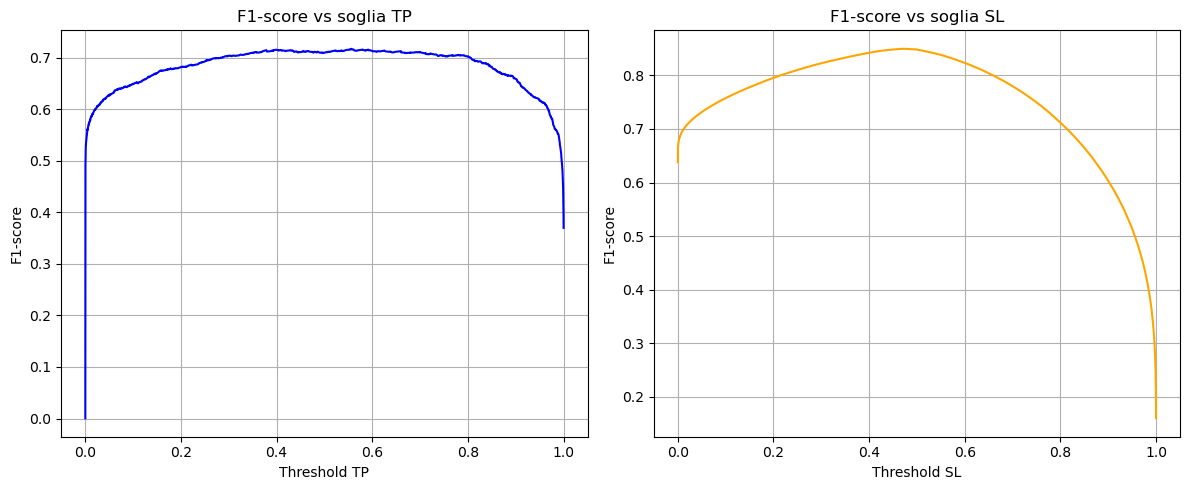

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# === Costruzione array target e probabilità ===
df_exploded = pd.DataFrame(exploded)
y_true = df_exploded["outcome"].to_numpy()

# Target binari separati
y_true_tp = (y_true == 1).astype(int)
y_true_sl = (y_true == -1).astype(int)

# Probabilità
prob_tp = df_exploded["prob_tp"].to_numpy()
prob_sl = df_exploded["prob_sl"].to_numpy()

# === Calcolo precision-recall per TP ===
prec_tp, rec_tp, thr_tp = precision_recall_curve(y_true_tp, prob_tp)
f1_tp = 2 * (prec_tp[:-1] * rec_tp[:-1]) / (prec_tp[:-1] + rec_tp[:-1] + 1e-9)

# === Calcolo precision-recall per SL ===
prec_sl, rec_sl, thr_sl = precision_recall_curve(y_true_sl, prob_sl)
f1_sl = 2 * (prec_sl[:-1] * rec_sl[:-1]) / (prec_sl[:-1] + rec_sl[:-1] + 1e-9)

# === Plot dei due grafici ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Grafico TP
ax1.plot(thr_tp, f1_tp, color='blue')
ax1.set_title("F1-score vs soglia TP")
ax1.set_xlabel("Threshold TP")
ax1.set_ylabel("F1-score")
ax1.grid(True)

# Grafico SL
ax2.plot(thr_sl, f1_sl, color='orange')
ax2.set_title("F1-score vs soglia SL")
ax2.set_xlabel("Threshold SL")
ax2.set_ylabel("F1-score")
ax2.grid(True)

plt.tight_layout()
plt.show()


In [90]:
from sklearn.metrics import classification_report


manual_thr_tp = 0.5561
manual_thr_sl = 0.4737
y_pred = np.zeros_like(y_true)
y_pred[prob_tp >= manual_thr_tp] = 1
mask_sl = (y_pred == 0) & (prob_sl >= manual_thr_sl)
y_pred[mask_sl] = -1

print(f"\n🎯 CLASSIFICATION REPORT con soglie fisse TP={manual_thr_tp}, SL={manual_thr_sl}:\n")
print(classification_report(
    y_true,
    y_pred,
    labels=[-1, 0, 1],
    target_names=["SL_hit", "No_hit", "TP_hit"]
))



🎯 CLASSIFICATION REPORT con soglie fisse TP=0.5561, SL=0.4737:

              precision    recall  f1-score   support

      SL_hit       0.84      0.86      0.85   1735445
      No_hit       0.87      0.85      0.86   1968545
      TP_hit       0.84      0.63      0.72      1010

    accuracy                           0.86   3705000
   macro avg       0.85      0.78      0.81   3705000
weighted avg       0.86      0.86      0.86   3705000



In [89]:
# === Migliori soglie basate su F1 ===
best_idx_tp = np.argmax(f1_tp)
best_thr_tp = thr_tp[best_idx_tp]

best_idx_sl = np.argmax(f1_sl)
best_thr_sl = thr_sl[best_idx_sl]

print(f"✅ Soglia ottimale TP: {best_thr_tp:.4f} (F1 = {f1_tp[best_idx_tp]:.4f})")
print(f"✅ Soglia ottimale SL: {best_thr_sl:.4f} (F1 = {f1_sl[best_idx_sl]:.4f})")


✅ Soglia ottimale TP: 0.5561 (F1 = 0.7169)
✅ Soglia ottimale SL: 0.4737 (F1 = 0.8496)
